In [1]:
import mne
import matplotlib.pyplot as plt

## Reading XDF EEG data

In [32]:
from utilities import read_xdf

# For Interact-UI, recommended run in .py file.
raw = read_xdf("Pipo_1_5_test1.xdf", show_plot=False, show_psd=False) 

Creating RawArray with float64 data, n_channels=8, n_times=49650
    Range : 0 ... 49649 =      0.000 ...   198.521 secs
Ready.


c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:30: RuntimeWarning: The unit for channel(s) obci_eeg1_0 has changed from NA to V.
  raw = read_raw_xdf(filename, stream_ids=[stream_id])
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:31: RuntimeWarning: The unit for channel(s) obci_eeg1_1 has changed from NA to V.
  # print(raw.info['bads'])
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:32: RuntimeWarning: The unit for channel(s) obci_eeg1_2 has changed from NA to V.
  
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:33: RuntimeWarning: The unit for channel(s) obci_eeg1_3 has changed from NA to V.
  # Set channel types
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:34: RuntimeWarning: The unit for channel(s) obci_eeg1_4 has changed from NA to V.
  #   set_channel_types({CHANNEL_NAME : CHANNEL_TYPE})
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:35: Run

### Plot show EEG data & PSD (overview)

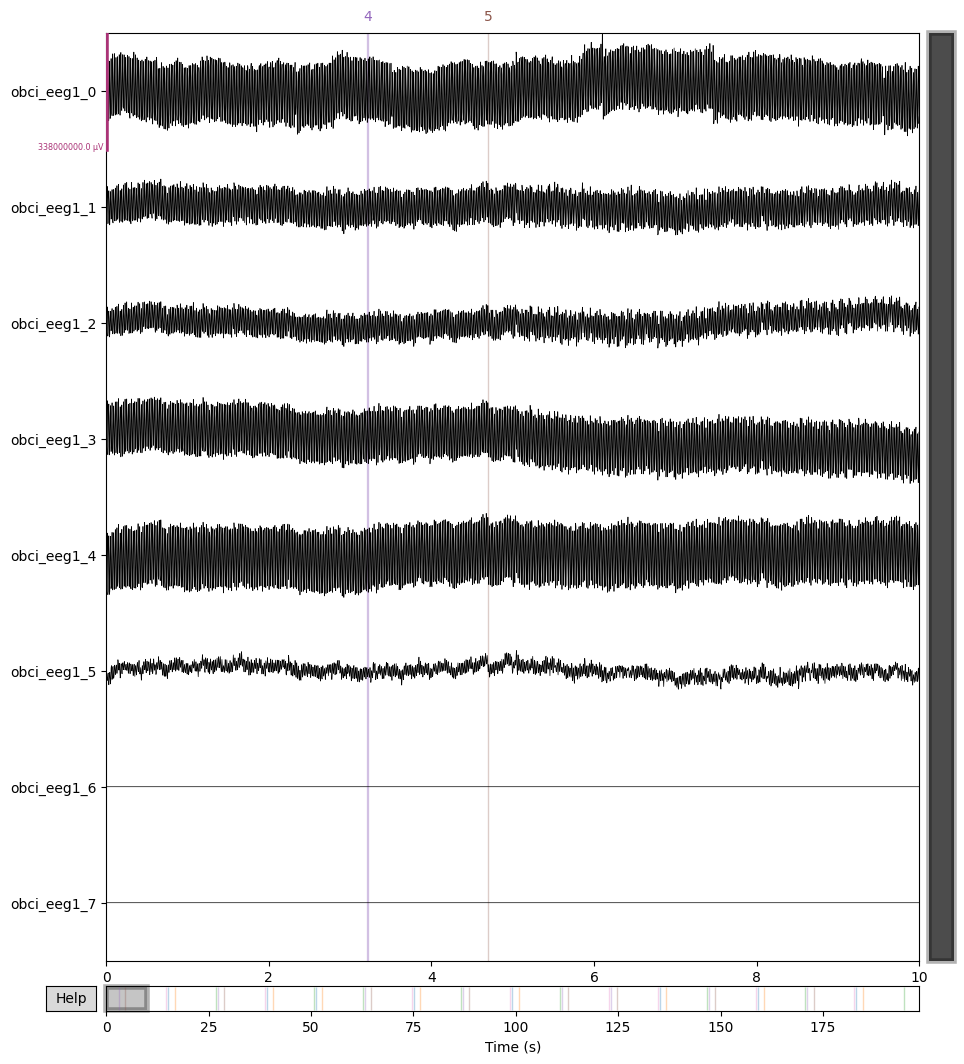

Effective window size : 1.024 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\seami\AppData\Local\Temp\ipykernel_13300\3413466856.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


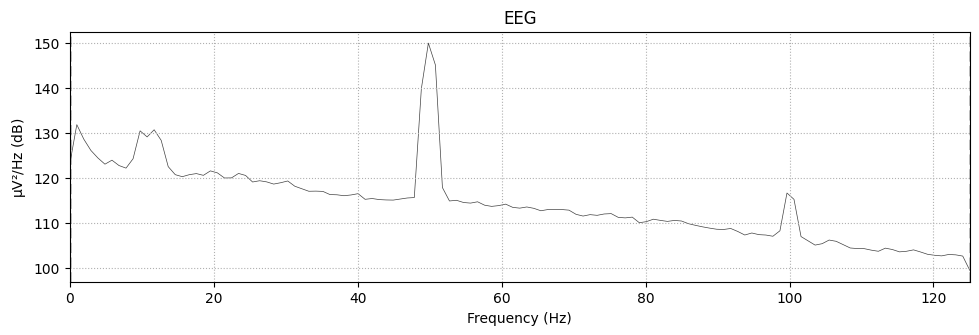

In [90]:
raw.plot(
    duration=10, 
    start=0.0, 
    scalings=169, # You may edit scalings value later
    )
raw.compute_psd(
    picks='obci_eeg1_1',    # pick by channel name
    # picks='eeg',          # pick by channel type
    ).plot()


### Bandpass Filtering

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


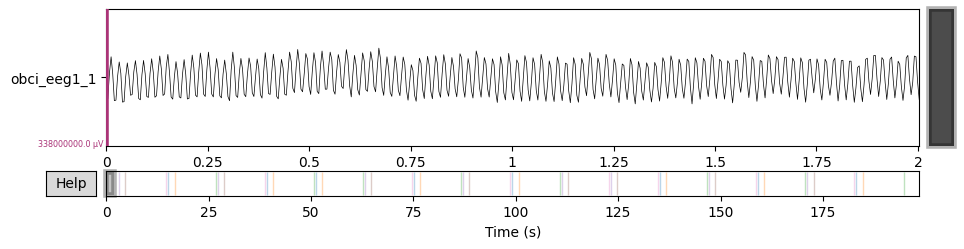

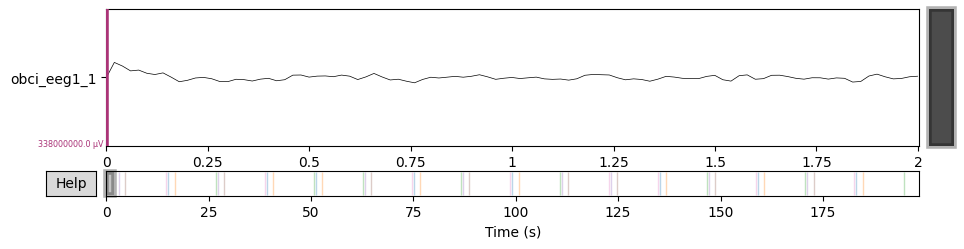

In [45]:
raw_bp = raw.copy().filter(l_freq=3.0, h_freq=15.0)

fig1 = raw.copy().pick('obci_eeg1_1').plot(
    duration=2, start=0.0, show=False,
    scalings=169, # You may edit scalings value later
    )
fig1.set_figheight(2); plt.show()

fig2 = raw_bp.copy().pick('obci_eeg1_1').plot(
    duration=2, start=0.0, show=False,
    scalings=169, # You may edit scalings value later
    )
fig2.set_figheight(2); plt.show()

### Event handle

In [91]:
print(raw.annotations)
# print(raw.annotations.onset[0])

<Annotations | 48 segments: 1 (8), 2 (8), 3 (8), 4 (8), 5 (8), 6 (8)>


**Our project event (annotations) types** (this information is not standardized)

1 : *Left cue start*

2 : *Left stimuli start*

3 : *Left blank start*

4 : *Right cue start*

5 : *Right stimuli start*

6 : *Right blank start*

In [46]:
annotations_des = {
    '1': 'Left cue start',
    '2': 'Left stimuli start',
    '3': 'Left blank start',
    '4': 'Right cue start',
    '5': 'Right stimuli start',
    '6': 'Right blank start',
}
raw_eeg = raw.pick_channels([ # Pick only O1, Oz, O2, POz, Pz
    'obci_eeg1_1', 'obci_eeg1_2', 'obci_eeg1_3', 'obci_eeg1_4', 'obci_eeg1_5'])
raw_eeg_bp = raw_bp.pick_channels([ # Pick only O1, Oz, O2, POz, Pz
    'obci_eeg1_1', 'obci_eeg1_2', 'obci_eeg1_3', 'obci_eeg1_4', 'obci_eeg1_5'])

# Read Event from annotations
events, event_dict = mne.events_from_annotations(raw_eeg)
print('Total events:', len(events))
# print(event_dict)
# print(events[:5])

Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Total events: 48


### Epoching

In [48]:
# Split Epochs (Trials)
epochs = mne.Epochs(raw_eeg, events, 
        tmin=0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=10,    # final timestamp (10 means set epoch duration 10 second)
        baseline=(0, 0),
        preload=True,
    )
epochs_bp = mne.Epochs(raw_eeg_bp, events, 
        tmin=0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=10,    # final timestamp (10 means set epoch duration 10 second)
        baseline=(0, 0),
        preload=True,
    )

Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2502 original time points ...
1 bad epochs dropped
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2502 original time points ...
1 bad epochs dropped


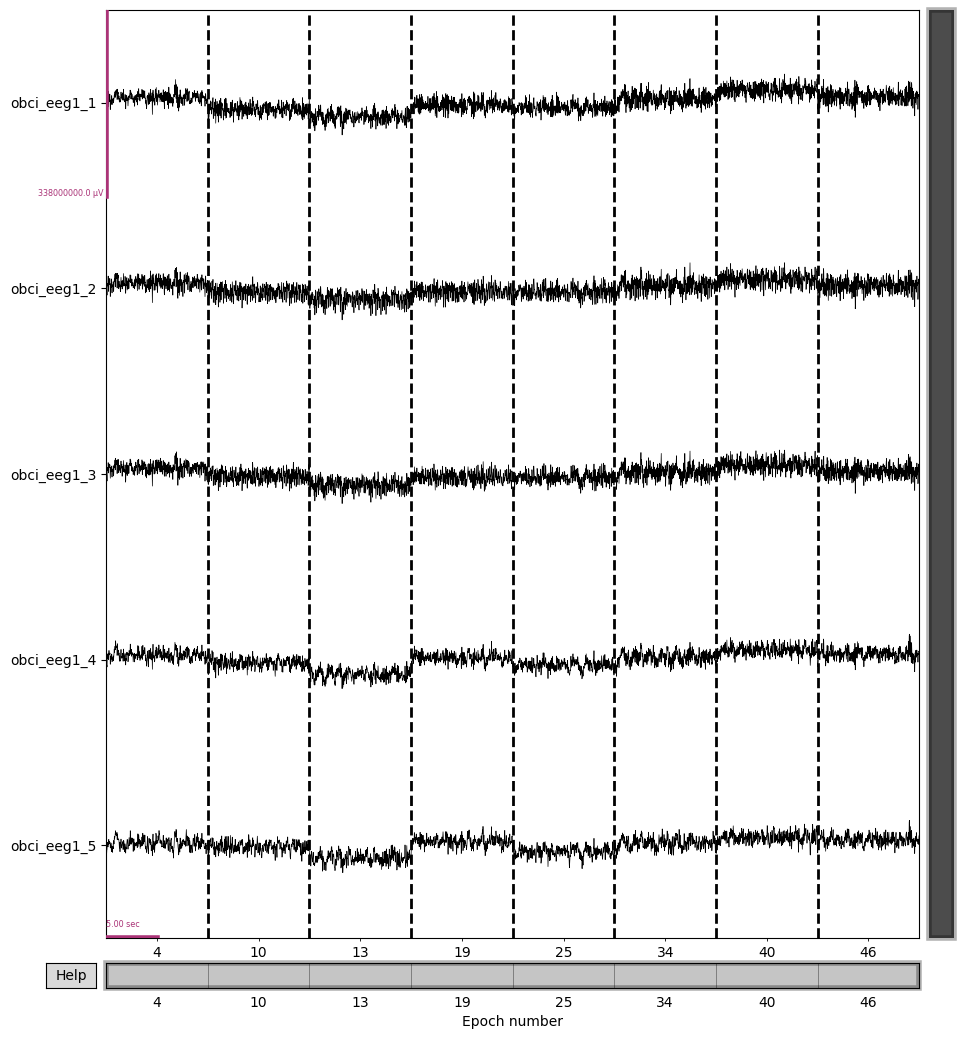

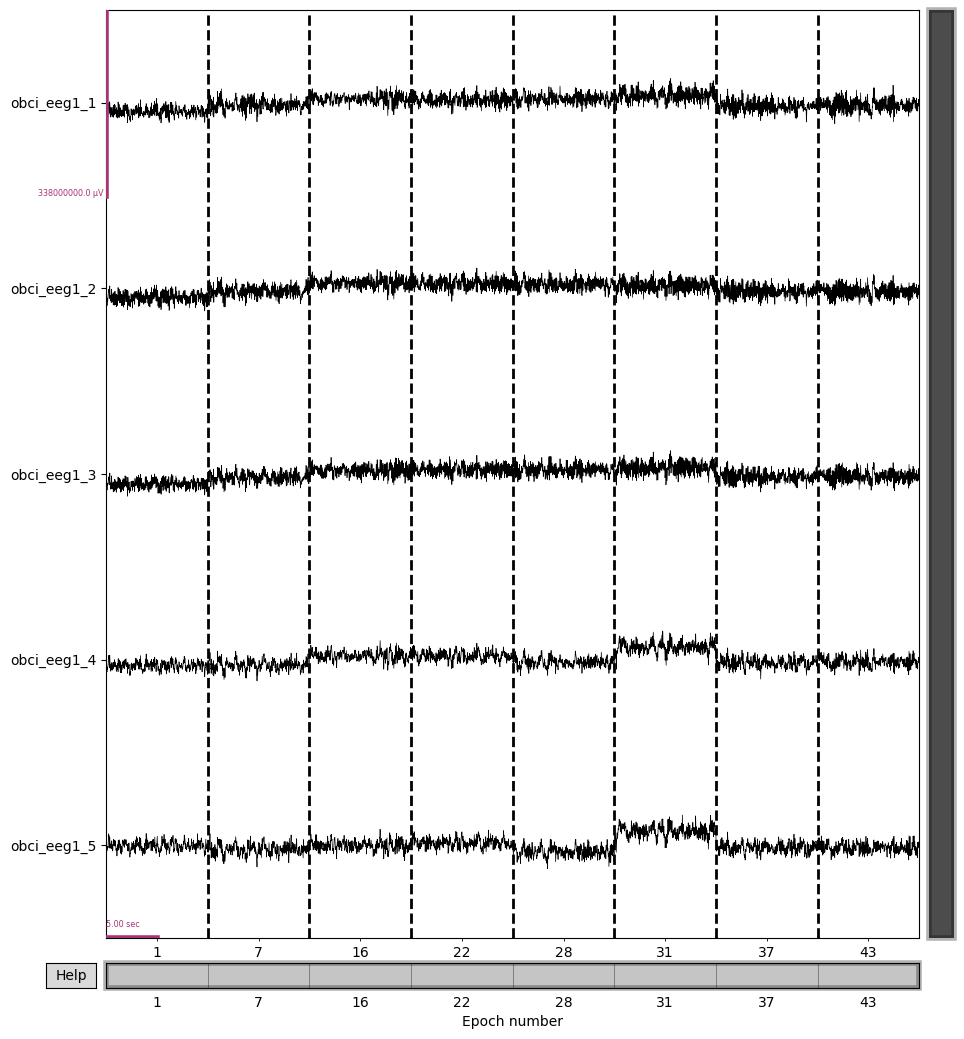

In [43]:
# Preview EEG split by epoch

# Select epoch (trial) of event '2' which is Left-stimuli
epochs['2'].plot(
    scalings=169, # You may edit scalings value later
    title='Left stimuli start',
)
# Select epoch (trial) of event '5' which is Right-stimuli
epochs['5'].plot(
    scalings=169, # You may edit scalings value later
    title='Right stimuli start',
)
plt.show()

### Plot PSD of Left-Right stimuli

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


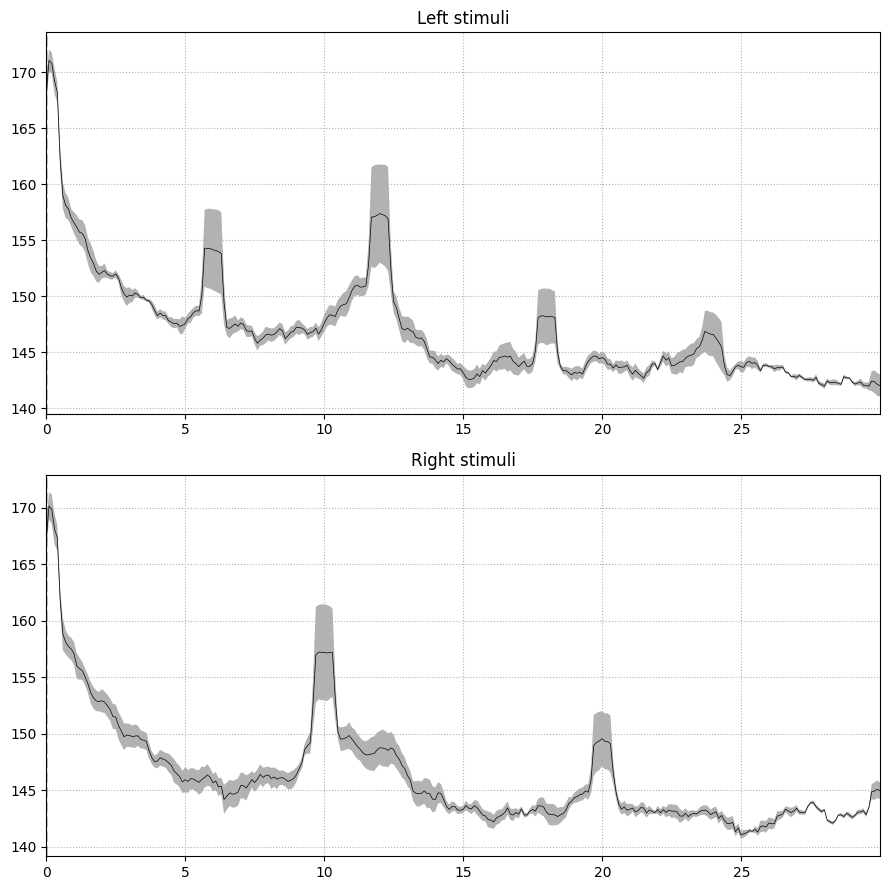

In [49]:
# from utilities import show_epoch
#
# show_epoch(raw)

fig, ax = plt.subplots(2, figsize=(9,9))

epochs['2'].compute_psd(
    fmax=30,                    
    ).plot(
        axes=ax[0],
        average=True,
        )
ax[0].set_title('Left stimuli')

epochs['5'].compute_psd(
    fmax=30,                    
    ).plot(
        axes=ax[1],
        average=True,
        )
ax[1].set_title('Right stimuli')

plt.tight_layout()
plt.show()

The Peak frequency of Left-stimuli is **6Hz**, 12Hz, 18Hz, ... (which is *Harmonic frequency*) and

the Peak frequency of Right-stimuli is **10Hz**, 20Hz, ... (which is *Harmonic frequency*)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


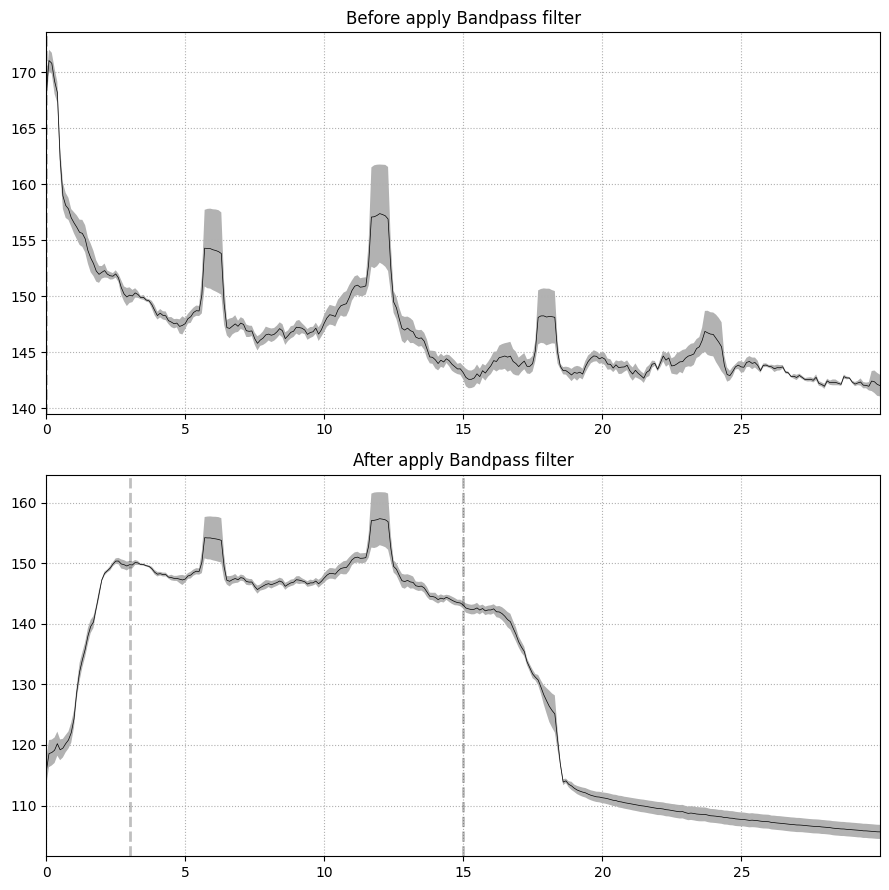

In [50]:
fig, ax = plt.subplots(2, figsize=(9,9))

epochs['2'].compute_psd(
    fmax=30,                    
    ).plot(
        axes=ax[0],
        average=True,
        )
ax[0].set_title('Before apply Bandpass filter')

# After Bandpass filtered
epochs_bp['2'].compute_psd(
    fmax=30,                    
    ).plot(
        axes=ax[1],
        average=True,
        )
ax[1].set_title('After apply Bandpass filter')

plt.tight_layout()
plt.show()

### Plot Time-frequency

In [ ]:
# Split Epochs (Trials) including Cue
epochs_from_cue = mne.Epochs(raw_eeg_bp, events, 
        tmin=-1.0,      # init timestamp of epoch (-1.0 means trigger before event start 1.0 second)
        tmax=10.0,      # final timestamp (10 means set epoch duration 10 second)
        # baseline=(0, 0),
        preload=True,
    )
channel_name = (    
    '(O1) obci_eeg1_1',
    '(Oz) obci_eeg1_2',
    '(O2) obci_eeg1_3',
    '(POz) obci_eeg1_4',
    '(Pz) obci_eeg1_5',)

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
plt.title('Time-frequency')

# Select range of frequency you wanna plot
show_freqs = list(range(1,25))
# show_freqs = [6.0, 12.0, 18.0, 24.0, 10.0, 20.0, 30.0]

for i in range(5):
    power_L = mne.time_frequency.tfr_multitaper(
        epochs_from_cue['2'], 
        freqs=show_freqs, 
        n_cycles=10, 
        use_fft=True, 
        decim=3,
        return_itc=False,
    )
    power_L.plot([i], mode='logratio', axes=ax[0,i], show=False, colorbar=False)
    ax[0,i].set_title('Left stimuli - '+channel_name[i]); ax[0,i].set_xlabel('')

    power_R = mne.time_frequency.tfr_multitaper(
        epochs_from_cue['5'], 
        freqs=show_freqs, 
        n_cycles=10, 
        use_fft=True, 
        decim=3,
        return_itc=False,
    )
    power_R.plot([i], mode='logratio', axes=ax[1,i], show=False, colorbar=False)
    ax[1,i].set_title('Right stimuli - '+channel_name[i])

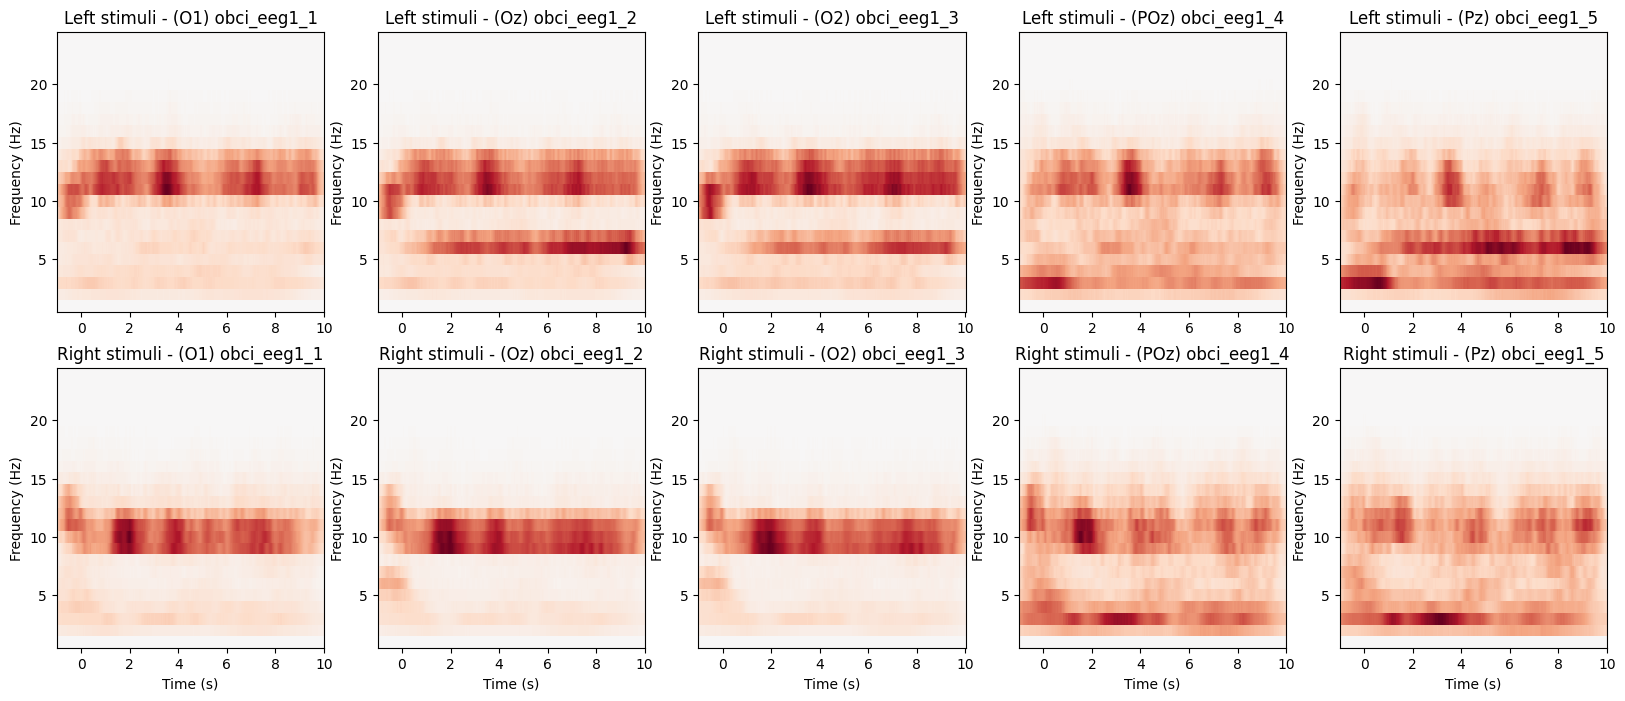

In [56]:
plt.show()

Found that when stimuli event start (at time=0) Frequency signal is very clear on **O1, Oz, O2** and kinda unclear on channel POz, Pz.